In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# Importing our custom functions
from standardize_datasets import get_merge_dataset
from standardize_datasets import get_lemmatized_dataset
from standardize_datasets import get_standardized_liar_dataset
from standardize_datasets import preprocess

from utils import confusion_matrix_improved, display_roc_curve

# Importing save/load functions
import pickle

# Importing visualization functions
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

In [15]:
# Definition of constants
RANDOM_SEED = 42
VOCAB_SIZE = 10_000
TEST_SIZE = 0.2
MAX_LENGTH = 1000

Get our dataset and split train/test data

In [14]:
df = get_lemmatized_dataset()
X_train, X_test, y_train, y_test = train_test_split(df['article'], df['label'], test_size=TEST_SIZE, random_state=RANDOM_SEED)

# Define our model

In [5]:
def define_model(max_vocab_size = 10_000, embedding_dim = 16):
    # Define tokenizer 
    
    

    #Using an LSTM model  
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_vocab_size, embedding_dim, mask_zero=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
model = define_model()
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-22 13:34:48.961765: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-22 13:34:48.962379: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, None, 64)          20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 195,329
Trainable params: 195,329
Non-trainable params: 0
_________________________________________________________________


# Training

We need to fit our tokenizer based in training data. It is necessary to save the tokenizer 

In [16]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE + 1, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [17]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

#Padding the sequences
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

y_test = np.asarray(y_test)
y_train = np.asarray(y_train)

In [99]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=1)
#with open('model/lstm_standard_embedding_tokenizer.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
model.save('model/lstm_standard_embedding_masking_maxlen100.h5')

Epoch 1/5
1802/1802 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.6571

2023-04-22 15:05:50.337869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-22 15:05:50.725455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-22 15:05:53.274794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1802/1802 [==============================] - 1256s 697ms/step - loss: 0.6436 - accuracy: 0.6571 - val_loss: 0.6435 - val_accuracy: 0.6566
Epoch 2/5
1802/1802 [==============================] - ETA: 0s - loss: 0.6435 - accuracy: 0.6571

In [ ]:
def display_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

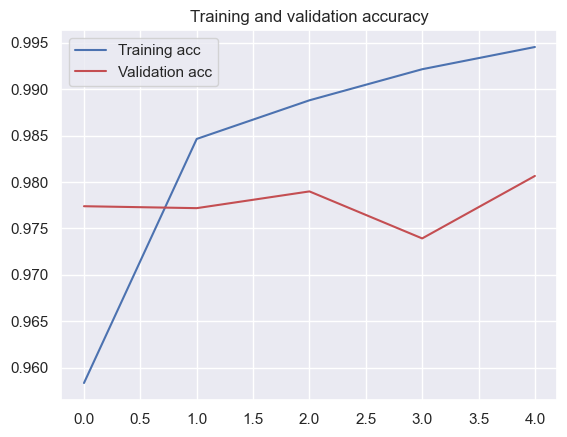

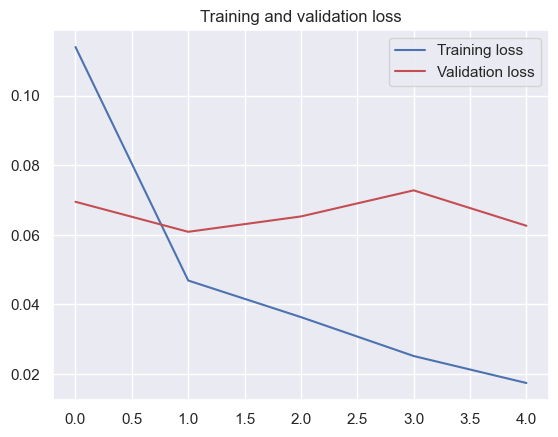

In [ ]:
display_history(history)

In [ ]:
## Loading the model if necessary
#model.load_weights('model/lstm_standard_embedding_masking_maxlen100.h5')

A first approach to evaluate the performance of the model is to display the confusion matrix

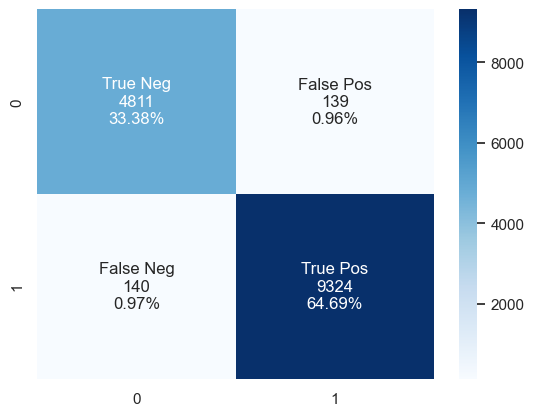

In [ ]:
# Display the confusion matrix rounding the predictions
y_pred = model.predict(X_test)
confusion_matrix_improved(y_test, y_pred.round(), labels=[0, 1])

Yet, the model outputs a value in the interval [0;1]. We need to affect a label thanks to a threshold. The ROC curve allows us to display the performance along all threshold

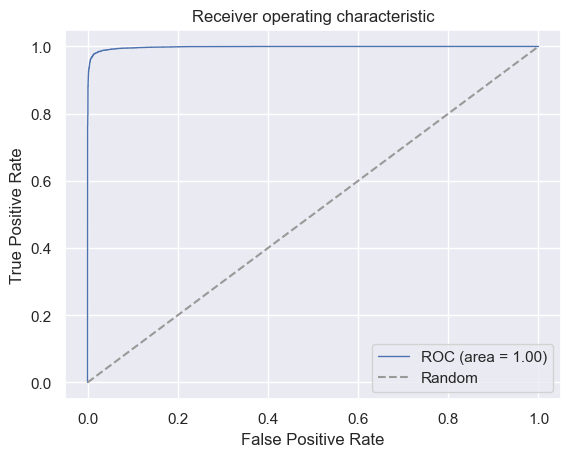

In [ ]:
display_roc_curve(y_pred, y_test)

# Call into questions of the model

The model seems too good. As the dataset is homemade, it is possible that it has biases which allow a simple classification.
Then the model in itself doesn't learn to classify satire but other feature in the dataset.

In [21]:
def predict_text(test):
    
    test = tokenizer.texts_to_sequences([test])
    print(test)
    return model.predict(test)
    

In [22]:
text = '''
Jupyter Notebook has been a favorite tool among data scientists for many years. It allows for an interactive, web-based environment that seamlessly integrates code, data, and visualizations. However, as the field of data science continues to evolve, Jupyter Notebook’s limitations have become increasingly apparent.
Jupyter Notebook’s drawbacks include the lack of version control, difficulties with debugging, incompatibility with certain libraries, large file sizes, and limited collaboration capabilities. While these drawbacks may not be significant for smaller projects, they can become major obstacles for larger, more complex projects. Some users have pointed out that workarounds exist, such as using Jupyter Notebooks in VSCode for debugging and utilizing Github Copilot for assistance.
Fortunately, there are many alternatives to Jupyter Notebook, including Integrated Development Environments (IDEs), text editors, cloud-based notebooks, and other interactive notebooks. Each of these tools has its own strengths and weaknesses, which we’ll explore in-depth in this updated article, taking into account valuable user feedback and experiences.
If you’re considering transitioning away from Jupyter Notebook or incorporating alternative tools, this article will guide you through the process. We’ll cover how to identify the reasons for switching, choose an alternative tool, and migrate existing Jupyter Notebook projects.

'''
print(predict_text(text))

[[1, 1, 1, 1, 47, 2477, 1831, 2491, 2430, 1, 236, 1316, 1, 8, 1, 236, 929, 6975, 2050, 1, 1178, 94, 1, 1, 1480, 2430, 83, 1, 313, 152, 5, 347, 468, 2430, 1954, 1, 319, 3798, 1, 1, 1, 114, 1, 1049, 2708, 1, 1, 1, 51, 5, 632, 468, 975, 318, 1, 396, 1, 1, 396, 935, 1, 268, 1403, 1, 83, 1923, 4653, 1, 391, 867, 1, 74, 725, 515, 593, 236, 1, 1, 102, 1727, 1, 291, 1, 236, 1, 1319, 1748, 1, 705, 1, 114, 1, 2458, 94, 1, 857, 2581, 152, 1, 1, 1, 23, 1, 236, 1, 83, 1, 1, 1, 236, 3911, 6438, 75, 1, 1316, 1, 319, 1, 1, 1, 1, 836, 1, 1, 1719, 1, 2441, 1, 1, 83, 1247, 6975, 1, 3800, 468, 867, 1, 1, 1781, 876, 1, 83, 1, 2262, 1, 2212, 23, 2281, 23, 56, 1, 571, 7507, 7307, 398, 2429, 469, 5412, 83, 1, 84, 1, 1, 1, 171, 1217, 1, 1, 1306, 1, 1227, 1, 56, 571, 1690, 2091, 134, 5814, 5, 395, 1, 592, 818, 319, 1350, 5, 1, 236, 1, 689, 929, 1227, 1831, 83, 1, 1, 1, 1, 1]]


2023-04-22 14:26:26.550754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-22 14:26:27.297550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-22 14:26:27.872218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step
[[0.62540835]]


# Test on another dataset

In [36]:
liar = get_standardized_liar_dataset()
liar = liar[0:100]
liar.head()

Found cached dataset liar (/Users/thomasloux/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514)


  0%|          | 0/3 [00:00<?, ?it/s]

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,12134.json,0,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1.0,0.0,1.0,0.0,0.0,an interview with ABC17 News
1,238.json,0,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,,,none,11.0,43.0,8.0,5.0,105.0,
2,7891.json,0,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0.0,1.0,1.0,1.0,0.0,a U.S. Ways and Means hearing
3,8169.json,1,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0.0,1.0,1.0,1.0,0.0,an opinion article
4,929.json,1,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,interview with CBS News


In [37]:
liar['statement'] = preprocess(liar['statement'], n_process=5)

In [38]:
def decide(probabilies, threshold=0.5):
    return np.where(probabilies > threshold, 1, 0)

In [93]:
liar_test = tokenizer.texts_to_sequences(liar['statement'])
liar_test = tf.keras.preprocessing.sequence.pad_sequences(liar_test, maxlen=MAX_LENGTH, padding='post')

print(liar_test)

[[  21  868   24 ...    0    0    0]
 [ 214 1198 3950 ...    0    0    0]
 [   4  114 1964 ...    0    0    0]
 ...
 [1820  358    1 ...    0    0    0]
 [   5  162 3443 ...    0    0    0]
 [2351    1 1173 ...    0    0    0]]


In [94]:
prediction = model.predict(liar_test)

2023-04-22 14:45:55.934805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-22 14:45:56.547589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-22 14:46:00.221214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 17s 3s/step


In [98]:
model.predict(liar_test[0:1])

1/1 [==============================] - 8s 8s/step


array([[0.65127367]], dtype=float32)

In [96]:
prediction

array([[0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.6512737 ],
       [0.65127367],
       [0.6512737 ],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.6512737 ],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.6512737 ],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.65127367],
       [0.651

(array([ 0., 88.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., 12.]),
 array([0.65127367, 0.65127367, 0.65127367, 0.65127367, 0.65127367,
        0.65127367, 0.65127367, 0.65127367, 0.65127367, 0.65127367,
        0.65127373, 0.65127373, 0.65127373, 0.65127373, 0.65127373,
        0.65127373, 0.65127373, 0.65127373, 0.65127373, 0.65127373,
        0.65127373]),
 <BarContainer object of 20 artists>)

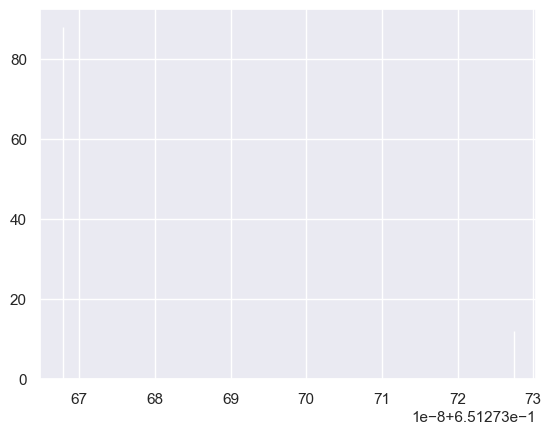

In [95]:
#display histogram
plt.hist(prediction, bins=20)

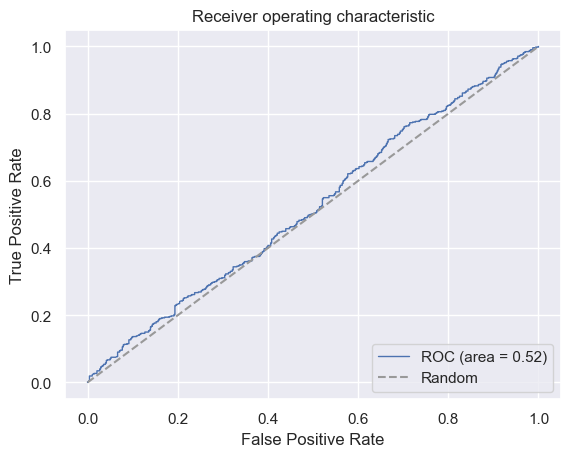

In [ ]:
display_roc_curve(liste, liar['label'])

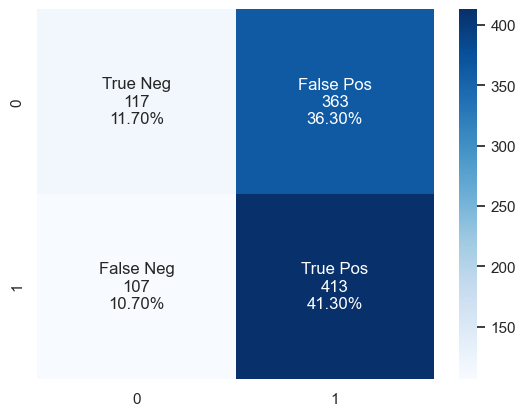

In [ ]:
confusion_matrix_improved(liar['label'], liste.round(), labels=[0, 1])

In [35]:
texts = tf.keras.preprocessing.sequence.pad_sequences(liar['statement_tokenized'], maxlen=50, padding='post')
results_post = model.predict(texts)

32/32 [==============================] - 1s 19ms/step


In [36]:
texts = tf.keras.preprocessing.sequence.pad_sequences(liar['statement_tokenized'], maxlen=50, padding='pre')
results = model.predict(texts)

32/32 [==============================] - 15s 473ms/step


In [27]:
texts[0:10]

array([[  21,  868,   24, ...,    0,    0,    0],
       [ 214, 1198, 3950, ...,    0,    0,    0],
       [   4,  114, 1964, ...,    0,    0,    0],
       ...,
       [   5,  517,  544, ...,    0,    0,    0],
       [   4,  851,  207, ...,    0,    0,    0],
       [ 379,  375,   46, ...,    0,    0,    0]], dtype=int32)

In [28]:
results[0:10]

array([[0.16312261],
       [0.15698999],
       [0.16283828],
       [0.16307603],
       [0.00069842],
       [0.00125228],
       [0.1632603 ],
       [0.16414376],
       [0.16041209],
       [0.16071948]], dtype=float32)

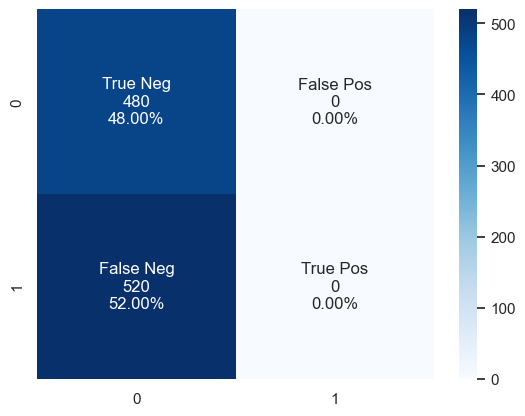

In [36]:
confusion_matrix_improved(liar['label'], results.round(), labels=[0, 1])

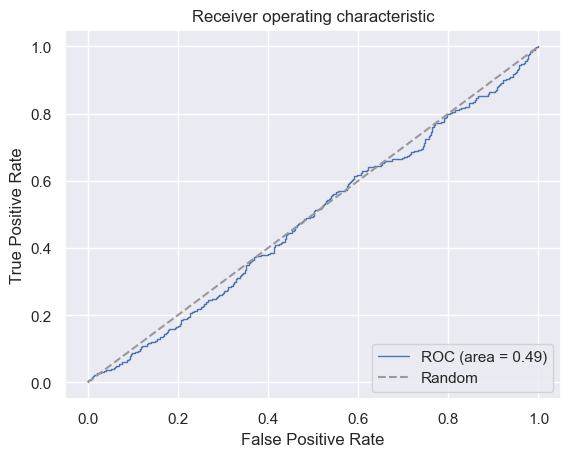

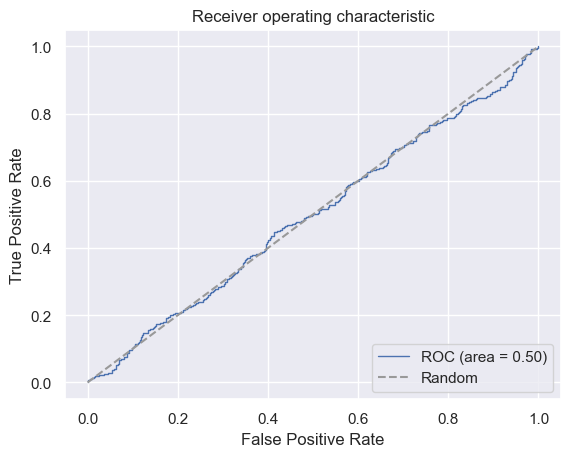

In [38]:
display_roc_curve(results_post, liar['label'])
display_roc_curve(results, liar['label'])

In [171]:
liar['statement'][5]

['say',
 'armed',
 'civilian',
 'stop',
 'mass',
 'shooting',
 'gun',
 ',',
 'average',
 '2.5',
 'people',
 'die',
 ';',
 ',',
 'average',
 '18',
 'people',
 'die',
 '.']

In [167]:
tokens = tokenizer.texts_to_sequences(liar['statement'])

AttributeError: 'list' object has no attribute 'flatten'